## First Simulation Study

### Load Libraries

In [1]:
import numpy as np
import scipy.stats as stats
##Library neural nets
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
# Library for Gaussian process
import GPy
##Library for visualization
import matplotlib as mpl
mpl.style.use("seaborn")
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 
import re

In [2]:
# split into input (X) and output (Y) variables
N = 1000 ##Sample Size
P = 1 ##Covariates
M = 100 ##replicates
X = np.array([np.ones(N)]).T ##Design matrix
kernel = GPy.kern.Exponential(1,1,0.1) ##Covariance Function
noise_var = 0.01 ##Nugget variance
# 1000 points evenly spaced over [0,1]
s = np.linspace(0,1,N).reshape(-1,1)
mu = np.ones(N).reshape(-1,1) # vector of the means
nugget = np.eye(N) * noise_var ##Nugget matrix
cov_mat = kernel.K(s) + nugget ##Covariance matrix
# Generate M sample path with mean mu and covariance C
np.random.seed(1)
y = np.random.multivariate_normal(mu[:,0],cov_mat,M).T

In [3]:
print(y.shape) ##check the dimension of y

(1000, 100)


### Visualize the Observation

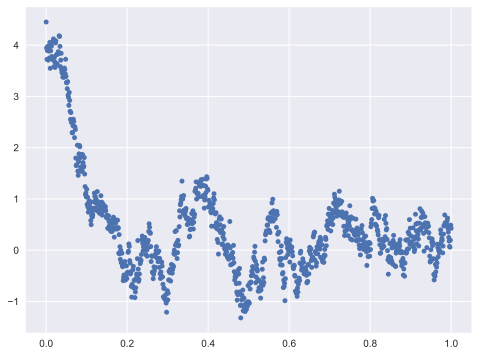

In [4]:
plt.plot(s,y[:,0],".",mew=1.5)
plt.show()### Create a neural network with three hidden layers
#plt.savefig("trueGP.pdf")

### Create a neural network with seven hidden layers

In [5]:
def create_mlp_7(feature_dim):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim = feature_dim,  kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model### Create a neural network with 7 hidden layers

### Generate basis functions

In [6]:
num_basis = [10,19,37,73]
knots = [np.linspace(0,1,i) for i in num_basis]
##Wendland kernel
K = 0 ## basis size
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/num_basis[res]*2.5
    for i in range(num_basis[res]):
        d = np.absolute(s-knots[res][i])/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

Check the dimension of $s$, $X$, $y$ and $\phi$

In [7]:
print(s.shape)
print(X.shape)
print(y.shape)
print(phi.shape)

(1000, 1)
(1000, 1)
(1000, 100)
(1000, 139)


### Split the data

In [8]:
from sklearn.model_selection import train_test_split
indices = np.arange(N)
## Split the training and testing sets
s_train, s_test, X_train, X_test, phi_train, phi_test\
    , y_train, y_test, idx_train, idx_test \
    = train_test_split(s, X, phi, y, indices, test_size=0.2)
N_train = s_train.shape[0]
N_test = s_test.shape[0]

** Only with X=1 **

In [10]:
model_1 = create_mlp_7(feature_dim = P)
 
# train the model
print("[INFO] training model 1...")
model_1.fit(X_train, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 1...


** With s and X **

In [11]:
model_2 = create_mlp_7(feature_dim = P + 1)
Xs_train = np.hstack((X_train,s_train)) 
# train the model
print("[INFO] training model 2...")
model_2.fit(Xs_train, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 2...


** With RBF and X **

In [12]:
model_3 = create_mlp_7(feature_dim = P + K)
XRBF_train = np.hstack((X_train,phi_train)) 
# train the model
print("[INFO] training model 3...")
train_history = model_3.fit(XRBF_train, y_train[:,0], epochs = 200, batch_size = 32, verbose = 0)

[INFO] training model 3...


In [13]:
Xs = np.hstack((X,s))
XRBF = np.hstack((X,phi))
y0_test_1 = model_1.predict(X)
y0_test_2 = model_2.predict(Xs)
y0_test_3 = model_3.predict(XRBF)

In [14]:
print([y0_test_1.shape,y0_test_2.shape,y0_test_3.shape])

[(1000, 1), (1000, 1), (1000, 1)]


### Truth from GP

In [15]:
##Warning: it is important to write 0:1 in GPRegression to get the size (Ntrain,1)
m = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train], kernel, noise_var = noise_var)
mu_GP,var_GP = m.predict(s)
lo95_GP,up95_GP = m.predict_quantiles(s)
y0_gp = mu_GP + mu

In [16]:
print(y0_gp.shape)

(1000, 1)


In [17]:
kernel2 = GPy.kern.Matern32(1,1,1)
m2 = GPy.models.GPRegression(s_train,y_train[:,0:1] - mu[idx_train],kernel2, noise_var = noise_var)
m2.optimize()
mu_GPE,var_GPE = m2.predict(s)
lo95_GPE,up95_GPE = m2.predict_quantiles(s)
y0_gpe = mu_GPE + mu

In [18]:
print(y0_gpe.shape)

(1000, 1)


### Visualize results

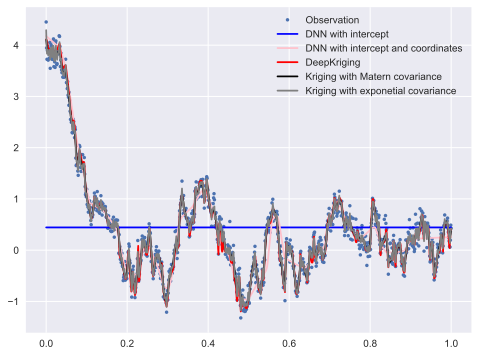

In [19]:
pylab.plot(s, y[:,0],".",label="Observation")
pylab.plot(s, y0_test_1,'blue',label="DNN with intercept")
pylab.plot(s, y0_test_2,'pink',label="DNN with intercept and coordinates")
pylab.plot(s, y0_test_3,'red',label="DeepKriging")
pylab.plot(s, y0_gpe,'black',label="Kriging with Matern covariance")
pylab.plot(s, y0_gp,'grey',label="Kriging with exponetial covariance")
pylab.legend(loc='upper right')
pylab.show()
#plt.savefig("1D_compare.pdf")

### MSE, MAE, and Nonlinearity

In [20]:
def rmse(y_true,y_pred):
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))
    return float(rmse)
def mape(y_true,y_pred):
    mape = np.mean(np.absolute(y_true-y_pred)/np.absolute(y_true))
    return float(mape)

In [ ]:
rmse_train_combine = np.zeros((5,M))
mape_train_combine = np.zeros((5,M))
rmse_test_combine = np.zeros((5,M))
mape_test_combine = np.zeros((5,M))

for i in range(M):
    print("[INFO] training %s-th replicate..." % (i+1))
    ##Kriging with exponential covariance
    m = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)], kernel, noise_var = noise_var)
    mu_GP_train,var_GP_train = m.predict(s_train)
    y_gp_train = mu_GP_train
    mu_GP_test,var_GP_test = m.predict(s_test)
    y_gp_test = mu_GP_test
    
    ##Kriging with Matern covariance
    kernel2 = GPy.kern.Matern32(1,1,1)
    m2 = GPy.models.GPRegression(s_train,y_train[:,i:(i+1)],kernel2, noise_var = noise_var)
    m2.optimize()
    mu_GPE_train,var_GPE_train = m2.predict(s_train)
    y_gpe_train = mu_GPE_train
    mu_GPE_test,var_GPE_test = m2.predict(s_test)
    y_gpe_test = mu_GPE_test
 
    ##DNN with intercept
    model_1.fit(X_train, y_train[:,i], epochs = 500, batch_size = 32, verbose = 0)
    y_dnn_train = model_1.predict(X[idx_train,:])
    y_dnn_test = model_1.predict(X[idx_test,:])
 
    ##DNN with intercept and coordinate
    model_2.fit(Xs_train, y_train[:,i], epochs = 500, batch_size = 32, verbose = 0)
    y_dnn2_train = model_2.predict(Xs[idx_train,:])
    y_dnn2_test = model_2.predict(Xs[idx_test,:])
    
    ##DeepKriging with seven hidden layers
    model_3.fit(XRBF_train, y_train[:,i], epochs = 200, batch_size = 32, verbose = 0)
    y_dk_train = model_3.predict(XRBF[idx_train,:])
    y_dk_test = model_3.predict(XRBF[idx_test,:])
    
   
    ##Save the results
    rmse_train_combine[:,i] = np.array([rmse(y_train[:,i],y_gp_train[:,0]),\
                                  rmse(y_train[:,i],y_gpe_train[:,0]),\
                                  rmse(y_train[:,i],y_dk_train[:,0]),\
                                  rmse(y_train[:,i],y_dnn_train[:,0]),\
                                  rmse(y_train[:,i],y_dnn2_train[:,0])])
    mape_train_combine[:,i] = np.array([mape(y_train[:,i],y_gp_train[:,0]),\
                                  mape(y_train[:,i],y_gpe_train[:,0]),\
                                  mape(y_train[:,i],y_dk_train[:,0]),\
                                  mape(y_train[:,i],y_dnn_train[:,0]),\
                                  mape(y_train[:,i],y_dnn2_train[:,0])])
    rmse_test_combine[:,i] = np.array([rmse(y_test[:,i],y_gp_test[:,0]),\
                                  rmse(y_test[:,i],y_gpe_test[:,0]),\
                                  rmse(y_test[:,i],y_dk_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn_test[:,0]),\
                                  rmse(y_test[:,i],y_dnn2_test[:,0])])
    mape_test_combine[:,i] = np.array([mape(y_test[:,i],y_gp_test[:,0]),\
                                  mape(y_test[:,i],y_gpe_test[:,0]),\
                                  mape(y_test[:,i],y_dk_test[:,0]),\
                                  mape(y_test[:,i],y_dnn_test[:,0]),\
                                  mape(y_test[:,i],y_dnn2_test[:,0])])

    print(rmse_train_combine[:,i])
    print(mape_train_combine[:,i])
    
    print(rmse_test_combine[:,i])
    print(mape_test_combine[:,i])

[INFO] training 1-th replicate...
[0.06129266 0.12853187 0.09774085 1.05375247 0.21907365]
[0.49460375 0.97930202 0.62000778 5.72860099 1.79553982]
[0.16240056 0.17262673 0.17087123 0.94470928 0.21921692]
[1.00559322 0.8668522  0.89113274 5.41851368 1.06856905]
[INFO] training 2-th replicate...
[0.06487197 0.1289624  0.10950165 1.22963455 0.22275348]
[0.14317066 0.30875918 0.21145238 2.37142882 0.39879341]
[0.17087402 0.17874351 0.1967721  1.24388674 0.23049013]
[0.22024285 0.23343728 0.2608517  1.57714801 0.2908023 ]
[INFO] training 3-th replicate...
[0.06126816 0.1243449  0.08923088 0.76205913 0.20074459]
[0.2570759  0.50730061 0.42916723 3.34015199 0.7887035 ]
[0.15002992 0.15691694 0.1639822  0.84493277 0.21108848]
[0.31518999 0.39775478 0.49354207 2.65789031 0.44088309]
[INFO] training 4-th replicate...
[0.06299128 0.12768808 0.0847649  0.80676071 0.19274919]
[0.19815489 0.43142505 0.24302834 4.18955965 0.60664105]
[0.16673714 0.17000906 0.17796389 0.8553136  0.22312128]
[1.299977

In [42]:
print(np.mean(rmse_train_combine,axis=1))
print(np.std(rmse_train_combine,axis=1))
print(np.mean(mape_train_combine,axis=1))
print(np.std(mape_train_combine,axis=1))

[0.12519207 0.12168969 0.10265667 0.10097917 0.08630404 0.09579024]
[0.00515445 0.02010111 0.01050041 0.01724435 0.01372311 0.02569086]


In [ ]:
print(np.mean(rmse_train_combine,axis=1))
print(np.std(rmse_train_combine,axis=1))
print(np.mean(mape_train_combine,axis=1))
print(np.std(mape_train_combine,axis=1))